In [73]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('/content/drive/MyDrive/DGdataset/Sample Time Series/daily/classification_attempt_3.csv' , index_col = 0)
df.head()

,Sample Index,Mean,Variance,Skewness,Kurtosis,Trend Mean,Seasonal Mean,Residual Mean,Best Model
0,0,1.170354e+06,4.007895e+10,1.398559,3.071583,1.170865e+06,-3.686601e+03,3176.103442,Prophet
1,1,1.173173e+06,4.021102e+10,1.345245,2.854922,1.173717e+06,-4.948876e+02,-48.892901,XGBoost
2,2,1.165945e+06,4.167459e+10,1.259848,2.653146,1.170509e+06,-2.861151e+03,-1702.486047,ARIMA
3,3,1.161884e+06,4.173290e+10,1.257650,2.661183,1.162507e+06,1.455192e-11,-623.829597,XGBoost
4,4,1.154895e+06,4.314659e+10,1.184845,2.477578,1.153841e+06,-1.812498e+03,2866.969396,ARIMA


<ipython-input-65-b207939247ec>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


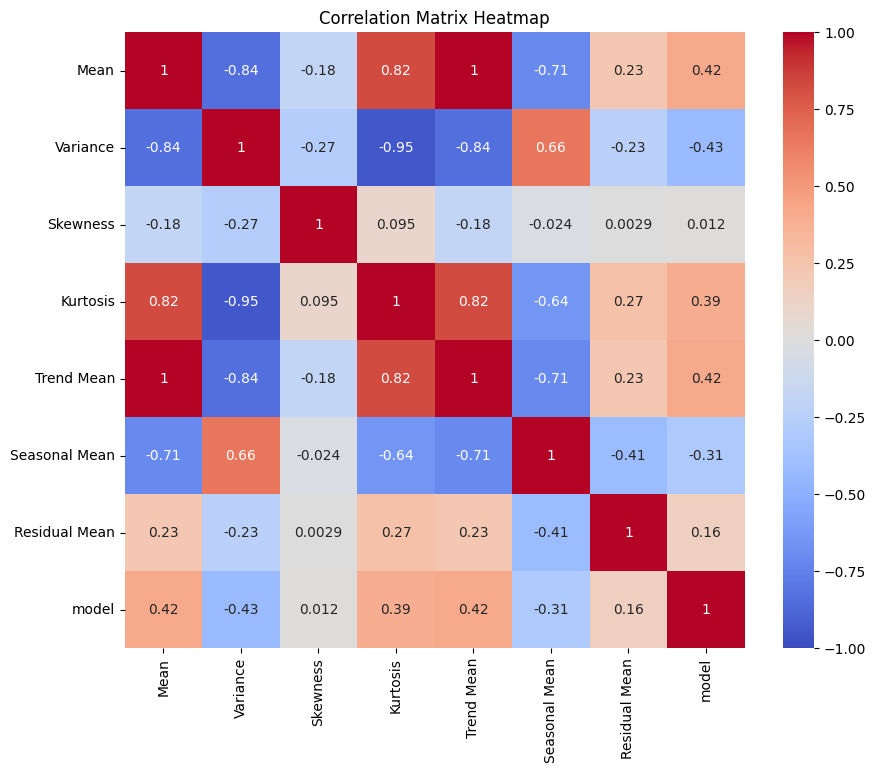

In [65]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [11]:
df.drop('Sample Index' , axis = 1 , inplace = True)

In [18]:
method_to_label = {'ARIMA': 0, 'XGBoost': 1, 'Prophet': 2, 'ETS': 3}
df['model'] = df['Best Model'].map(method_to_label)

In [19]:
df.head()

,Mean,Variance,Skewness,Kurtosis,Trend Mean,Seasonal Mean,Residual Mean,Best Model,model
0,1.170354e+06,4.007895e+10,1.398559,3.071583,1.170865e+06,-3.686601e+03,3176.103442,Prophet,2
1,1.173173e+06,4.021102e+10,1.345245,2.854922,1.173717e+06,-4.948876e+02,-48.892901,XGBoost,1
2,1.165945e+06,4.167459e+10,1.259848,2.653146,1.170509e+06,-2.861151e+03,-1702.486047,ARIMA,0
3,1.161884e+06,4.173290e+10,1.257650,2.661183,1.162507e+06,1.455192e-11,-623.829597,XGBoost,1
4,1.154895e+06,4.314659e+10,1.184845,2.477578,1.153841e+06,-1.812498e+03,2866.969396,ARIMA,0


In [20]:
df_encoded = pd.get_dummies(df, columns=['model'], prefix='method')
df_encoded.head()

,Mean,Variance,Skewness,Kurtosis,Trend Mean,Seasonal Mean,Residual Mean,Best Model,method_0,method_1,method_2,method_3
0,1.170354e+06,4.007895e+10,1.398559,3.071583,1.170865e+06,-3.686601e+03,3176.103442,Prophet,0,0,1,0
1,1.173173e+06,4.021102e+10,1.345245,2.854922,1.173717e+06,-4.948876e+02,-48.892901,XGBoost,0,1,0,0
2,1.165945e+06,4.167459e+10,1.259848,2.653146,1.170509e+06,-2.861151e+03,-1702.486047,ARIMA,1,0,0,0
3,1.161884e+06,4.173290e+10,1.257650,2.661183,1.162507e+06,1.455192e-11,-623.829597,XGBoost,0,1,0,0
4,1.154895e+06,4.314659e+10,1.184845,2.477578,1.153841e+06,-1.812498e+03,2866.969396,ARIMA,1,0,0,0


In [74]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

rf_classifier = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)


pipeline = Pipeline([
    ('clf', grid_search)
])
shuffled_df = df.sample(frac=1, random_state=42)

X = shuffled_df.drop(['model', 'Best Model'], axis=1)
y = shuffled_df['model']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
best_rf_model = pipeline.named_steps['clf'].best_estimator_
best_params = pipeline.named_steps['clf'].best_params_

with open('random_forest_model_grid_cv_1.pkl', 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Accuracy: 0.625
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.25      0.20      0.22         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3

    accuracy                           0.62        40
   macro avg       0.26      0.28      0.27        40
weighted avg       0.53      0.62      0.58        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
# Load the model from the file
with open('/content/random_forest_model_grid_cv_1.pkl', 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)

# Now you can use the loaded model for predictions
predictions = loaded_rf_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.25      0.20      0.22         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3

    accuracy                           0.62        40
   macro avg       0.26      0.28      0.27        40
weighted avg       0.53      0.62      0.58        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Apply SMOTE for oversampling
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [60]:
X = df.drop(['model', 'Best Model'], axis=1)
y = np.array(df_encoded[['method_0', 'method_1', 'method_2', 'method_3']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        29
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

   micro avg       0.71      0.60      0.65        40
   macro avg       0.19      0.21      0.20        40
weighted avg       0.54      0.60      0.57        40
 samples avg       0.60      0.60      0.60        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
X = df.drop(['model', 'Best Model'], axis=1)
y = df['model']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.77        29
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.60        40
   macro avg       0.18      0.21      0.19        40
weighted avg       0.53      0.60      0.56        40

